In [7]:
!conda install -c conda-forge wget -y

Channels:
 - conda-forge
 - defaults
Platform: osx-arm64
Solving environment: done

# All requested packages already installed.



In [7]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Part 1: Download and Load the Corpus
!wget https://www.gutenberg.org/files/1041/1041-0.txt -O tiny_corpus.txt
with open('tiny_corpus.txt', 'r', encoding='utf-8') as file:
    corpus = file.read()

# Use a larger subset of the corpus to improve training
corpus = corpus[:500000]  # Limit the corpus size to 500,000 characters


--2024-10-23 16:00:23--  https://www.gutenberg.org/files/1041/1041-0.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 100231 (98K) [text/plain]
Saving to: ‘tiny_corpus.txt’

tiny_corpus.txt     100%[===================>]  97.88K  --.-KB/s    in 0.1s    

2024-10-23 16:00:23 (743 KB/s) - ‘tiny_corpus.txt’ saved [100231/100231]



In [ ]:
# Part 2: Initialize and Fit the Text Vectorization Layer
corpus_lines = corpus.split('\n')
text_ds = tf.data.Dataset.from_tensor_slices(corpus_lines).batch(1024)  # Batch to reduce memory usage

# Define TextVectorization layer
vectorizer = keras.layers.TextVectorization(output_mode='int', output_sequence_length=None)
vectorizer.adapt(text_ds)

# Convert the entire corpus to a sequence of numbers
sequence = vectorizer(corpus_lines)
input_sequences = []

# Generate n-grams from the numerical representation
for seq in sequence:
    for i in range(1, len(seq)):
        n_gram_sequence = seq[:i + 1]
        input_sequences.append(n_gram_sequence.numpy())

# Pad sequences to ensure uniform length
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(keras.preprocessing.sequence.pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# Create X and y from the Padded Sequences
Xs = input_sequences[:, :-1]
labels = input_sequences[:, -1]
ys = tf.keras.utils.to_categorical(labels, num_classes=len(vectorizer.get_vocabulary()))

In [8]:
# Part 3: Define and Compile the Model using Sequential API
model = Sequential([
    Embedding(input_dim=len(vectorizer.get_vocabulary()),output_dim=64),
    SimpleRNN(64),
    Dropout(0.7),
    Dense(len(vectorizer.get_vocabulary()), activation='softmax')
])

optimizer = Adam(learning_rate=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(Xs, ys, epochs=10, batch_size=128, validation_split=0.2, verbose=1)

Epoch 1/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.3304 - loss: 6.2805 - val_accuracy: 0.4033 - val_loss: 4.5725
Epoch 2/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - accuracy: 0.4185 - loss: 4.4047 - val_accuracy: 0.4033 - val_loss: 4.2287
Epoch 3/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - accuracy: 0.4145 - loss: 4.1454 - val_accuracy: 0.4060 - val_loss: 4.2005
Epoch 4/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4246 - loss: 3.9911 - val_accuracy: 0.4066 - val_loss: 4.2114
Epoch 5/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4237 - loss: 3.9427 - val_accuracy: 0.4085 - val_loss: 4.2157
Epoch 6/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 7s 34ms/step - accuracy: 0.4250 - loss: 3.8856 - val_accuracy: 0.4111 - val_loss: 4.2104
Epoch 7/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 27ms/step - accuracy: 0.4336 - loss: 3.7542 - val_accuracy: 0.4098 - val_loss: 4.2411
Epoch 8/10
165/165 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - accuracy: 0.4331 - loss: 3.7350 - val_accu

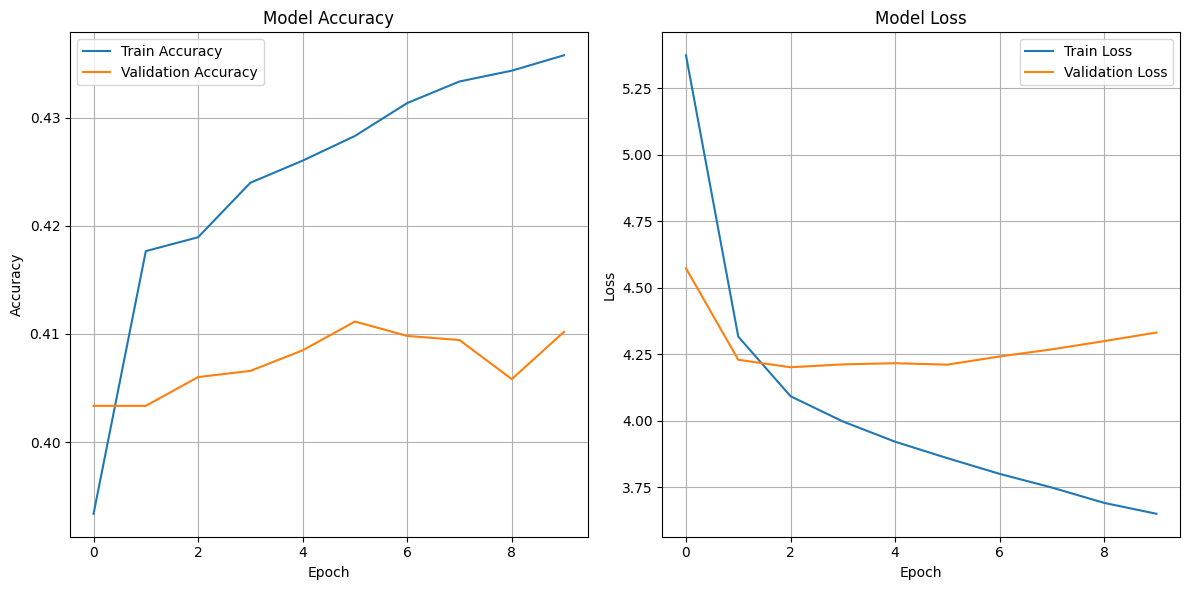

In [9]:
# Part 4: Plot Training History
def plot_training_history(history):
    plt.figure(figsize=(12, 6))

    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_training_history(history)


In [10]:
# Part 5: Generate Shakespearean-like Text
def generate_text(model, vectorizer, seed_text, max_sequence_len, next_words=10, temperature=1.0):
    for _ in range(next_words):
        token_list = vectorizer([seed_text])
        token_list = keras.preprocessing.sequence.pad_sequences(token_list, maxlen=max_sequence_len - 1, padding='pre')

        probabilities = model.predict(token_list, verbose=0)[0]
        probabilities = np.log(probabilities + 1e-7) / temperature
        exp_preds = np.exp(probabilities)
        probabilities = exp_preds / np.sum(exp_preds)

        predicted_index = np.random.choice(len(probabilities), p=probabilities)

        if predicted_index != 0:
            output_word = vectorizer.get_vocabulary()[predicted_index]
            seed_text += " " + output_word
    return seed_text


In [12]:
seed_text = "ROMEO: "
print(generate_text(model, vectorizer, seed_text, max_sequence_len=max_sequence_len, next_words=20, temperature=0.5))

ROMEO:  i all love the toil of thee with it
